# Tópicos em otimização

Prof. Claudio Tadeu Cristino

Aluno Aldemar S. R. Filho


## Enchentes

##### Links
solver cbc
https://github.com/coin-or/COIN-OR-OptimizationSuite/raw/master/Installer/files/doc/cbcCommandLine.pdf

solver glpk
https://en.wikibooks.org/wiki/GLPK/Using_GLPSOL

## Mapa

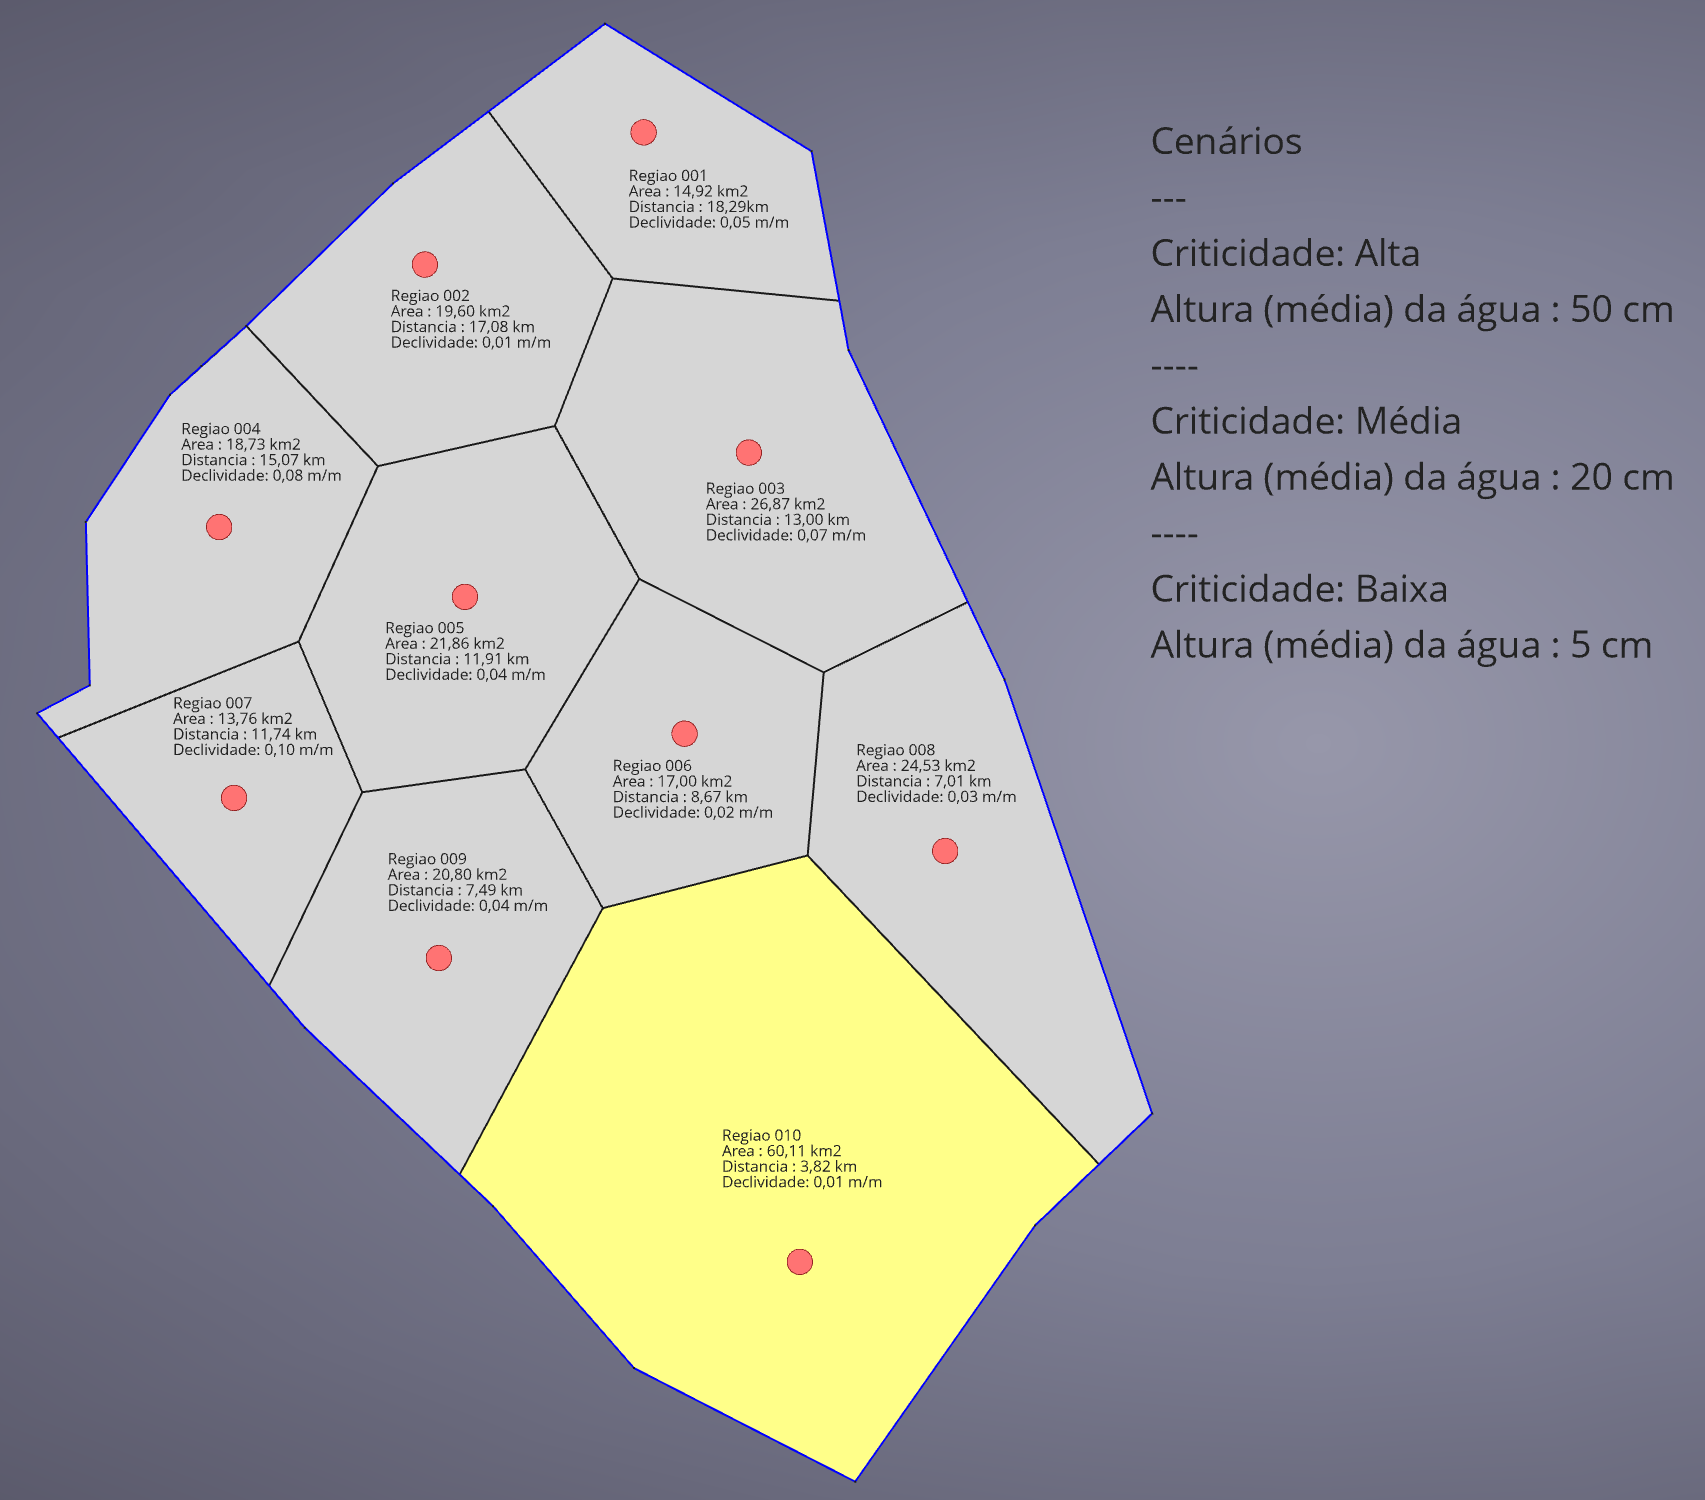

In [1]:
import time
import locale
import logging
import statistics
import numpy as np

from pyomo.environ import *
from locale import format_string
from scipy.optimize import linprog



logging.basicConfig(encoding='utf-8', level=logging.CRITICAL)

locale.setlocale(locale.LC_ALL, 'pt_BR.utf-8')

'pt_BR.utf-8'

In [2]:
regions = {
    1: {
        'index': 1,
        'area': 14.92, # km2
        'distance': 18.29, # km
        'slope': 0.05, # m/m
        'C': 0.51, # %
    },
    2: {
        'index': 2,
        'area': 19.60,
        'distance': 17.08,
        'slope': 0.01,
        'C': 0.56,
    },
    3: {
        'index': 3,
        'area': 26.87,
        'distance': 13.00,
        'slope': 0.07,
        'C': 0.55,
    },
    4: {
        'index': 4,
        'area': 18.73,
        'distance': 15.07,
        'slope': 0.08,
        'C': 0.52,
    },
    5: {
        'index': 5,
        'area': 21.86,
        'distance': 11.91,
        'slope': 0.04,
        'C': 0.64,
    },
    6: {
        'index': 6,
        'area': 17.00,
        'distance': 8.67,
        'slope': 0.02,
        'C': 0.60,
    },
    7: {
        'index': 7,
        'area': 13.76,
        'distance': 11.74,
        'slope': 0.10,
        'C': 0.57,
    },
    8: {
        'index': 8,
        'area': 24.53,
        'distance': 7.01,
        'slope': 0.03,
        'C': 0.57,
    },
    9: {
        'index': 9,
        'area': 20.80,
        'distance': 7.49,
        'slope': 0.04,
        'C': 0.70,
    },
}

target = {
        'index': 'Target',
        'area': 60.11,
        'distance': 3.82,
        'slope': 0.01,
        'C': 0.75,
    }

# In meters per hour
water_level_rates = {
    'low': 0.10,
    'medium': 0.25,
    'high': 0.50,
    }

# In cubic meters per hour
critical_volume_rates = {
    'low': round(target['area'] * 10**6 * water_level_rates['low']),
    'medium': round(target['area'] * 10**6 * water_level_rates['medium']),
    'high': round(target['area'] * 10**6 * water_level_rates['high']),
}

print(f'Níveis de criticidade')
print('-'*38)

for n, volume in critical_volume_rates.items():
    print(f'{n:<7}  {format_string("%d", volume, grouping=True):>10} m³/h  |  {water_level_rates[n]:>.2f} m/h')

Níveis de criticidade
--------------------------------------
low       6.011.000 m³/h  |  0.10 m/h
medium   15.027.500 m³/h  |  0.25 m/h
high     30.055.000 m³/h  |  0.50 m/h


$$
\begin{gather*}
\\
    \LARGE \text{Escoamento superficial -- Método Racional} \\
    \\
    Q_{s} = \frac{C \cdot i \cdot A}{360} \text{, onde:} \\
    \\
    Q_{s} \text{ - Escoamento superficial em } m^3/s \\
    C \text{ - Coeficiente de escoamento superficial (run off)} \\
    i \text{ - Intensidade máxima média da precipitação em } mm/h \\
    A \text{ - Área de drenagem (contribuição) em } ha
    \\
\end{gather*}
$$


<!-- $$
\begin{gather*}
    \Large \text{Intensidade da precipitação ($i$)} \\
    \\
    i = \frac{K \cdot T^{a}}{(t + b)^{c}} \text{, onde:}\\
    \\
    T \text{ - Período de retorno (anos)} \\
    t \text{ - Duração da precipitação (min)} \\
    K, a, b, c \text{ - Parâmetros de ajuste, relativos a estação pluviométrica} \\
    \\
    \text{Para Recife/PE:}\\
    \\
    i = \frac{335,47 \cdot T^{0,218}}{(t + 4)^{0,539}} \hspace{3mm} \text{(ENCIBRA, apud SILVA 2011)} \\
\end{gather*}
$$

*<p style="text-align: center;">SILVA, P. O.. Análise de técnicas compensatórias de drenagem urbana para atenuação de inundações em uma sub-bacia do rio Jiquiá no Recife. Dissertação de Mestrado do Programa de Pós-Graduação em Engenharia Civil da Universidade Federal de Pernambuco, Recife - PE, 139 p., 2011.</p>* -->


$$
\begin{gather*}
    \Large \text{Duração da precipitação ($t$)} \sim \text{Tempo de concentração ($t_{c}$)} \\
    \\
    \text{Equação de Kirpich}
    \\
    t_{c} = 57 \cdot (\frac{L^{3}}{H})^{0385} \text{, onde:}\\
    \\
    t_{c} \text{ - Tempo de concentração (min)} \\
    L \text{ - comprimento do curso d'água principal (km)} \\
    H \text{ - Diferença de nível ponto mais alto e saída considerada} \\
\end{gather*}
$$


$$
\begin{gather*}
    \Large \text{Coeficiente de escoamento ($C$)} \\
    \\
    \text{Valores adotados pela prefeitura de São Paulo/SP}
\end{gather*}
$$

<div style="margin: auto; width: fit-content;">

| Zonas                                                                                                                                             |      C       |
| :------------------------------------------------------------------------------------------------------------------------------------------------ | :----------: |
| **Edificação muito densa**:<br> Partes centrais, densamente construídas de uma cidade com ruas e calçadas pavimentadas                                | **0,70 - 0,95**  |
| **Edificações não muito densa**:<br> Parte adjacente ao centro, de menos densidade de habit.,mas com ruas e calçadas pavim.                           | **0,60 - 0,70**  |
| **Edificações com poucas superfícies livres**:<br> Partes residenciais com construções cerradas, ruas pavimentadas                                    | **0,50 - 0,60**  |
| Edificações com muitas superfícies livres:<br> Partes resid. com ruas macadamizadas ou paviment.                                                  | 0,25 - 0,50  |
| Subúrbios com alguma edificação:<br> Partes de arrabaldes e subúrbios com pequena densidade de construção                                         | 0, 10 - 0,25 |
| Matas, parques e campo de esportes:<br> Partes rurais, áreas verdes, superfícies arborizadas, parques ajardinados, campos de esporte s/ paviment. | 0, 05 - 0,20 |

</div>


$$
\begin{gather*}
    \Large \text{Entradas} \\
    \\
    i \text{ - intensidades da chuva } (mm/h) \\
    d \text{ - duração da chuva } (min) \\
\end{gather*}
$$


$$
\Large \text{Cálculos iniciais e testes}
$$

In [3]:
def print_region_data(intensity, duration, tc, qh, nah, cc, K, calc_k, nahc, region, text_pad: int, num_pad: int):
    print(f'Região {region["index"]}')
    print('-'*55)
    print(f'{"Coef. de escoamento":<{text_pad}}: {region["C"]:>{num_pad}.2f} (adim)')
    print(f'{"Intensidade da chuva":<{text_pad}}: {intensity:>{num_pad}} (mm/h)')
    print(f'{"Duração da chuva":<{text_pad}}: {duration:>{num_pad}} (min)')
    print('- '*28)

    print(f'{"Tempo de concentração":<{text_pad}}: {tc:>{num_pad}.4} min')
    print(f'{"Vazão de escoamento":<{text_pad}}: {format_string("%d", qh, grouping=True):>{num_pad}} m³/h')
    print(f'{"Taxa de acrescimo do NA":<{text_pad}}: {nah:>{num_pad}.4f} m/h')
    print(f'{"Coef. de contribuição":<{text_pad}}: {cc:>{num_pad}.4f} (adim)')
    print(f'{"Coeficiente K":<{text_pad}}: {K:>{num_pad}.10f} (mm . min)⁻1')

    print('\nContribuição unitária')
    print('=' * 40)
    print(f'{"Cálculo utilizando K":<{text_pad}}: {calc_k:>{num_pad}}')  # m/h
    print(f'{"Cálculo convencional":<{text_pad}}: {nahc:>{num_pad}}')
    print('\n')

In [4]:
# ESCOAMENTO SUPERFICIAL

# VALORES FIXOS PARA FACILITAR COMPARAÇÃO DOS CALCULOS
I = 20
D = 60 * 4

rs = [regions[i] for i in regions if i < 10]  # Regiões

# i_r = [int(random.triangular(5, 30, 20)) for _ in rs]  # Intensidade das chuvas nas regiões (mm/h)
# d_r = [int(random.triangular(20, 180, 60)) for _ in rs]  # Duração das chuvas nas regiões (min)

i_r = [I for _ in rs]  # Intensidade das chuvas nas regiões (mm/h)
d_r = [D for _ in rs]  # Duração das chuvas nas regiões (min)

tx_na = []
Qs = []

quads = [(r, i, d) for i, d, r in zip(i_r, d_r, rs)]
# print(quads)

for region, intensity, duration in quads:
    C = region['C']
    area = region['area'] * 100  # km2 -> ha (10⁴ m²)
    
    # TEMPO DE CONCENTRAÇÃO
    # CALCULADO COM A DISTANCIA DA ÁREA DE CAPTAÇÃO PARA O "ALVO"
    # CONSIDERADO O TEMPO NECESSÁRIO PARA O VOLUME CHEGAR AO "ALVO"

    # tc = 57 * (region['distance'] ** 3 / (region['slope'] * region['distance']))**0385 / 60
    tc = 57 * (region['distance']**2 / region['slope'])**0.385 / 60

    # qs = (C * i * area) / 360  # m3/s
    # qh = qs * 60 * 60  # m3/s -> m3/h
    qh = C * intensity * area * 10

    # TAXA DE ACRESCIMO NO NÍVEL D'ÁGUA DA REGIÃO ALVO
    nah = qh / (target['area'] * 10**6)  # m/h

    # COEFICIENTE DE CONTRIBUIÇÃO
    # Duração da chuva sobre o tempo para toda a bacia contribuir
    cc = duration / tc  # adim

    Qs.append(qh)
    nahc = round(nah * cc, 10)  # m/h
    tx_na.append(nahc)

    K = (region['C'] * area * 10) / (tc * target['area'] * 10**6)  # 1/(min . mm)

    calc_k = round(K * intensity * duration, 10)

    if not nahc == calc_k:
        raise ValueError('Valores divergem. Verificar cálculos!')
    
    print_region_data(intensity, duration, tc, qh, nah, cc, K, calc_k, nahc, region, 24, 13)

d_avg = int(statistics.mean(d_r))  # Minutos
tss = sum(tx_na) * d_avg / 60

print('SOMATÓRIO')
print('-'*70)
print(f'Taxa de acréscimo do N.A. acumulada: {sum(tx_na)*100:.2f} cm/h | {sum(tx_na):.4f} m/h')
print(f'Acréscimo do N.A. acumulado em {d_avg:} min [{d_avg/60:.1f} h]: {tss*100:.2f} cm | {tss:.4f} m')

Região 1
-------------------------------------------------------
Coef. de escoamento     :          0.51 (adim)
Intensidade da chuva    :            20 (mm/h)
Duração da chuva        :           240 (min)
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Tempo de concentração   :         28.22 min
Vazão de escoamento     :       152.184 m³/h
Taxa de acrescimo do NA :        0.0025 m/h
Coef. de contribuição   :        8.5052 (adim)
Coeficiente K           :  0.0000044861 (mm . min)⁻1

Contribuição unitária
Cálculo utilizando K    :  0.0215332113
Cálculo convencional    :  0.0215332113


Região 2
-------------------------------------------------------
Coef. de escoamento     :          0.56 (adim)
Intensidade da chuva    :            20 (mm/h)
Duração da chuva        :           240 (min)
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Tempo de concentração   :         49.74 min
Vazão de escoamento     :       219.520 m³/h
Taxa de acrescimo do NA :        0.0037 m/h
Coef.

<!-- $$
\begin{gather*}
\Large \text{Equações e simplificações} \\
\\
t_{n} = \frac{Q_{n} \cdot cc_{n}}{A} \text{ [$m/h$]} \\
\\
cc = \frac{d_{n}}{t_{cn}} \\
\\
Q_{n} = \frac{C_{n} \cdot i_{n} \cdot a_{n}}{360} \text{ [$m³/s$]} \\
\\
Q_{n} = \frac{C_{n} \cdot i_{n} \cdot a_{n} \cdot 60 \cdot 60}{360} \Rightarrow C_{n} \cdot i_{n} \cdot a_{n} \cdot 10 \text{ [$m³/h$]} \\
\\
t_{n} = 10 \cdot C_{n} \cdot i_{n} \cdot a_{n} \cdot \frac{d_{n}}{t_{cn}} \cdot A^{-1} \\
\\
t_{n} = (\frac{10 \cdot C_{n} \cdot a_{n}}{t_{cn} \cdot A}) \cdot i_{n} \cdot d_{n} \\
\\
K_{n} = 10 \cdot \frac{C_{n} \cdot a_{n}}{t_{cn} \cdot A} \text{ [$m/(mm \cdot min)$]} \\
\\
\Rightarrow t_{n} = K_{n} \cdot i_{n} \cdot d_{n} \\
\end{gather*}
$$ -->


$$
\begin{gather*}
\Large \text{Equações e simplificações} \\
\\
t_{n} = \frac{Q_{n} \cdot cc_{n}}{A} \text{ [$m/h$]} \\
\\
\text{Onde: }\\
\text{$t_{n}$ - taxa de acréscimo do nível de água da região - variável} \\
\text{$Q_{n}$ - Escoamento superficial em m³/s - constante} \\
\text{$cc_{n}$ - coeficiente de contribuição - constante} \\
\text{$A$ - Área da região alvo - constante} \\
\\
cc = \frac{d_{n}}{t_{cn}} \\
\\
\text{Onde: }\\
\text{$d_{n}$ - duração da chuva em min. - variável fixada} \\
\text{$t_{cn}$ - tempo de concentração (duração mínima da chuva para contribuição plena da vazão) - constante} \\
\\
Q_{n} = \frac{C_{n} \cdot i_{n} \cdot a_{n}}{360} \text{ [$m³/s$]} \\
\\
Q_{n} = \frac{C_{n} \cdot i_{n} \cdot a_{n} \cdot 60 \cdot 60}{360} \Rightarrow C_{n} \cdot i_{n} \cdot a_{n} \cdot 10 \text{ [$m³/h$]} \\
\\
\text{Onde: }\\
\text{$C_{n}$ - coeficiente de escoamento superficial (adimensional) - constante} \\
\text{$i_{n}$ - intensidade da chuva em mm/h - variável} \\
\text{$a_{n}$ - Área da região contribuinte - constante} \\
\text{$360$ | 60 | $10$ - constantes para conversão de unidade} \\
\text{$a_{n}$ - Área da região contribuinte - constante} \\

\\
t_{n} = 10 \cdot C_{n} \cdot i_{n} \cdot a_{n} \cdot \frac{d_{n}}{t_{cn}} \cdot A^{-1} \\
\\
t_{n} = (\frac{10 \cdot C_{n} \cdot a_{n}}{t_{cn} \cdot A}) \cdot i_{n} \cdot d_{n} \\
\\
K_{n} = 10 \cdot \frac{C_{n} \cdot a_{n}}{t_{cn} \cdot A} \text{ [$m/(mm \cdot min)$]} \\
\\
\Rightarrow t_{n} = K_{n} \cdot i_{n} \cdot d_{n} \\
\\
\text{Onde: }\\
\text{$K_{n}$ - coeficiente de contribuição de nível de água - constante por região} \\
\end{gather*}
$$


In [5]:
def print_k_calc(region, tc, K, intensity, duration, text_pad, num_pad):
    print(f'Região {region["index"]}')
    print('-'*50)
    print(f'{"Coef. de escoamento":<{text_pad}} {region["C"]:>{num_pad}.2f} (admin)')
    print(f'{"Área da região":<{text_pad}} {region["area"]:>{num_pad}.2f} km²')
    print(f'{"Tempo de concentração":<{text_pad}} {int(tc):>{num_pad}} min')
    print(f'{"Contribuição unitária":<{text_pad}} {K * intensity * duration:>{num_pad}.6f} m/h')
    print(f'{"Coeficiente K":<{text_pad}} {K:.10f} (mm . min)⁻1')
    print('\n')

$$
\Large \text{Cálculos da nova variável K}
$$

In [6]:
# ESCOAMENTO SUPERFICIAL
Ks = []

intensity = I
duration = D

for region in regions.values():
    area = region['area'] * 100  # km2 -> ha
    
    # TEMPO DE CONCENTRAÇÃO
    # CALCULADO COM A DISTANCIA DA ÁREA DE CAPTAÇÃO PARA O "ALVO"
    # CONSIDERADO O TEMPO NECESSÁRIO PARA O VOLUME CHEGAR AO "ALVO"

    # tc = 57 * (region['distance'] ** 3 / (region['slope'] * region['distance']))**0385 / 60
    tc = 57 * (region['distance']**2 / region['slope'])**0.385 / 60

    K = 10 * (region['C'] * area) / (tc * target['area'] * 10**6)

    Ks.append(K)

    print_k_calc(region, tc, K, intensity, duration, 24, 8)

ts = [K * intensity * duration for K in Ks]  # m/h
tss = sum(ts)

nas = tss * duration / 60  # m

print('SOMATÓRIO')
print('-'*62)
print(f'Taxa de acréscimo do N.A. acumulada: {tss*100:.2f} cm/h | {tss:.4f} m/h')
print(f'Acréscimo do N.A. acumulado em {duration} min: {nas*100:.2f} cm | {nas:.4f} m')

Região 1
--------------------------------------------------
Coef. de escoamento          0.51 (admin)
Área da região              14.92 km²
Tempo de concentração          28 min
Contribuição unitária    0.021533 m/h
Coeficiente K            0.0000044861 (mm . min)⁻1


Região 2
--------------------------------------------------
Coef. de escoamento          0.56 (admin)
Área da região              19.60 km²
Tempo de concentração          49 min
Contribuição unitária    0.017620 m/h
Coeficiente K            0.0000036708 (mm . min)⁻1


Região 3
--------------------------------------------------
Coef. de escoamento          0.55 (admin)
Área da região              26.87 km²
Tempo de concentração          19 min
Contribuição unitária    0.061920 m/h
Coeficiente K            0.0000128999 (mm . min)⁻1


Região 4
--------------------------------------------------
Coef. de escoamento          0.52 (admin)
Área da região              18.73 km²
Tempo de concentração          20 min
Contribuição un

$$
\LARGE \text{Definição do problema no formato de programação linear}
$$

$$
\begin{gather*}
\LARGE \text{Função objetivo} \\
\\
\Large \text{min. } \sum\limits_{n=1}^{m} t_{n} \hspace{10mm} \Rightarrow \hspace{5mm} \text{min. } \sum\limits_{n=1}^{m} (K_{n} \cdot i_{n} \cdot d_{n}) \\
\\
\text{onde,} \\
\text{$t_{n}$ - Taxa de elevação do nível de água $(m/h)$} \\
\text{$i_{n}$ - Intensidade da chuva $(mm/h)$} \\
\text{$K_{n}$ - Coeficiente de elevação do nível de água $(mm \cdot min)^{-1}$} \\
\text{$d_{n}$ - Duração da chuva - fixada - $(min)$} \\
\end{gather*}
$$


<!-- $$
\begin{gather*}
\\
\text{min } \hspace*{5mm} z = k_{1} \cdot i_{1} + k_{2} \cdot i_{2} + k_{3} \cdot i_{3} + k_{4} \cdot i_{4} + k_{5} \cdot i_{5} + k_{6} \cdot i_{6} + k_{7} \cdot i_{7} + k_{8} \cdot i_{8} + k_{9} \cdot i_{9} \\
\\
k_{1} \cdot i_{1} + k_{2} \cdot i_{2} + k_{3} \cdot i_{3} + k_{4} \cdot i_{4} + k_{5} \cdot i_{5} + k_{6} \cdot i_{6} + k_{7} \cdot i_{7} + k_{8} \cdot i_{8} + k_{9} \cdot i_{9} \geq \text{\{nível objetivo\}} \\
\\
i_{1}, i_{2}, i_{3}, i_{4}, i_{5}, i_{6}, i_{7}, i_{8}, i_{9} \geq 5 \\
\\
i_{1}, i_{2}, i_{3}, i_{4}, i_{5}, i_{6}, i_{7}, i_{8}, i_{9} \leq 70 \\
\\

\end{gather*}
$$ -->


$$
\begin{gather*}
\LARGE \text{Restrições} \\
\\
t_{1} + t_{2} + t_{3} + t_{4} + t_{5} + t_{6} + t_{7} + t_{8} + t_{9} = \text{\{nível objetivo\}} \\
\\
i_{n} > 0 \\
\\
i_{n} \leq {variável} \\
\\
% d_{n} \geq 30 \text{ min} \\
% \\
% d_{n} \leq 360 \text{ min} \\
% \\

\end{gather*}
$$


In [7]:
# duration = D / 2
# critical_value = volume_levels['high'] / (target['area'] * 10**6) / duration
# print(critical_value)

# bounds = (5, 70)

# model = ConcreteModel("Enchentes")

# #Define variables i's and d's
# model.i1 = Var (domain = NonNegativeIntegers, bounds=bounds)
# # model.d1 = Var (domain = NonNegativeIntegers, bounds=(20, 10 * 360))

# model.i2 = Var (domain = NonNegativeIntegers, bounds=bounds)
# # model.d2 = Var (domain = NonNegativeIntegers, bounds=(20, 10 * 360))

# model.i3 = Var (domain = NonNegativeIntegers, bounds=bounds)
# # model.d3 = Var (domain = NonNegativeIntegers, bounds=(20, 10 * 360))

# model.i4 = Var (domain = NonNegativeIntegers, bounds=bounds)
# # model.d4 = Var (domain = NonNegativeIntegers, bounds=(20, 10 * 360))

# model.i5 = Var (domain = NonNegativeIntegers, bounds=bounds)
# # model.d5 = Var (domain = NonNegativeIntegers, bounds=(20, 10 * 360))

# model.i6 = Var (domain = NonNegativeIntegers, bounds=bounds)
# # model.d6 = Var (domain = NonNegativeIntegers, bounds=(20, 10 * 360))

# model.i7 = Var (domain = NonNegativeIntegers, bounds=bounds)
# # model.d7 = Var (domain = NonNegativeIntegers, bounds=(20, 10 * 360))

# model.i8 = Var (domain = NonNegativeIntegers, bounds=bounds)
# # model.d8 = Var (domain = NonNegativeIntegers, bounds=(20, 10 * 360))

# model.i9 = Var (domain = NonNegativeIntegers, bounds=bounds)
# # model.d9 = Var (domain = NonNegativeIntegers, bounds=(20, 10 * 360))

# #Define objectives
# # model.obj = Objective (expr = 
# #                        model.i1 * model.d1 + 
# #                        model.i2 * model.d2 + 
# #                        model.i3 * model.d3 + 
# #                        model.i4 * model.d4 + 
# #                        model.i5 * model.d5 + 
# #                        model.i6 * model.d6 + 
# #                        model.i7 * model.d7 + 
# #                        model.i8 * model.d8 + 
# #                        model.i9 * model.d9,
# #                        sense = maximize)

# #Define Constraints
# # model.cons1 = Constraint (expr = model.i1, lb=5, up=70)
# # model.cons2 = Constraint (expr = model.i2, lb=5, up=70)
# # model.cons3 = Constraint (expr = model.i3, lb=5, up=70)
# # model.cons4 = Constraint (expr = model.i4, lb=5, up=70)
# # model.cons5 = Constraint (expr = model.i5, lb=5, up=70)
# # model.cons6 = Constraint (expr = model.i6, lb=5, up=70)
# # model.cons7 = Constraint (expr = model.i7, lb=5, up=70)
# # model.cons8 = Constraint (expr = model.i8, lb=5, up=70)
# # model.cons9 = Constraint (expr = model.i9, lb=5, up=70)

# # model.cons10 = Constraint (expr = model.i1 >= 5)
# # model.cons11 = Constraint (expr = model.i2 >= 5)
# # model.cons12 = Constraint (expr = model.i3 >= 5)
# # model.cons13 = Constraint (expr = model.i4 >= 5)
# # model.cons14 = Constraint (expr = model.i5 >= 5)
# # model.cons15 = Constraint (expr = model.i6 >= 5)
# # model.cons16 = Constraint (expr = model.i7 >= 5)
# # model.cons17 = Constraint (expr = model.i8 >= 5)
# # model.cons18 = Constraint (expr = model.i9 >= 5)

# # model.cons18 = Constraint (expr = model.d1 >= 30)
# # model.cons19 = Constraint (expr = model.d2 >= 30)
# # model.cons20 = Constraint (expr = model.d3 >= 30)
# # model.cons21 = Constraint (expr = model.d4 >= 30)
# # model.cons22 = Constraint (expr = model.d5 >= 30)
# # model.cons23 = Constraint (expr = model.d6 >= 30)
# # model.cons24 = Constraint (expr = model.d7 >= 30)
# # model.cons25 = Constraint (expr = model.d8 >= 30)
# # model.cons26 = Constraint (expr = model.d9 >= 30)

# # model.cons27 = Constraint (expr = model.d1 <= 360)
# # model.cons28 = Constraint (expr = model.d2 <= 360)
# # model.cons29 = Constraint (expr = model.d3 <= 360)
# # model.cons30 = Constraint (expr = model.d4 <= 360)
# # model.cons31 = Constraint (expr = model.d5 <= 360)
# # model.cons32 = Constraint (expr = model.d6 <= 360)
# # model.cons33 = Constraint (expr = model.d7 <= 360)
# # model.cons34 = Constraint (expr = model.d8 <= 360)
# # model.cons35 = Constraint (expr = model.d9 <= 360)

# # model.cons36 = Constraint (expr = 
# #                        model.i1 * model.d1 + 
# #                        model.i2 * model.d2 + 
# #                        model.i3 * model.d3 + 
# #                        model.i4 * model.d4 + 
# #                        model.i5 * model.d5 + 
# #                        model.i6 * model.d6 + 
# #                        model.i7 * model.d7 + 
# #                        model.i8 * model.d8 + 
# #                        model.i9 * model.d9 >= 6_011_000)

# model.cons36 = Constraint (expr = Ks[0] * model.i1 + 
#                            Ks[1] * model.i2 + 
#                            Ks[2] * model.i3 + 
#                            Ks[3] * model.i4 + 
#                            Ks[4] * model.i5 + 
#                            Ks[5] * model.i6 + 
#                            Ks[6] * model.i7 + 
#                            Ks[7] * model.i8 + 
#                            Ks[8] * model.i9 >= critical_value)

$$
\LARGE \text{Pyomo}
$$

$\text{Pyomo é mais flexível na definição dos modelos e permite, sem conversões, maximizar ou minimizar o objetivo.}$

$\text{Utiliza solvers externos, no caso o GNU Linear Programming Kit (glpk) e o COIN-OR Cut and Branch (cbc).}$

$$ \Large \text{Configuração do modelo} $$

In [8]:
def print_result(model: ConcreteModel, vars: Var) -> None:
    print('RESULTADOS')
    print('-'*11)

    # values = [f'i[{n+1}]: {value(vars[n+1]):.2f}' for n in range(len(vars))]
    for n in range(len(vars)):
        if n % 2 == 0:
            print(f'{f"i[{n+1}]:":<4} {value(vars[n+1]):>5}', end='')
        else:
            print(f'  |  {f"i[{n+1}]:":<4} {value(vars[n+1]):>5}')
    print('\n')

    print(f'Valor alcançado pela função objetivo: {value(model.obj):.6f}')


def print_model_specs(level, duration, critical_value, n_vars, bounds: tuple[int, int], text_pad) -> None:
    delimiter_len = 70

    translate = {
        'low': 'baixo',
        'medium': 'médio',
        'high': 'alto',
    }

    print('*' * delimiter_len)
    print(f'{"Nível de criticidade":<{text_pad}} {translate.get(level).upper()}')
    print(f'{"Duração da chuva":<{text_pad}} {duration} min')
    print(f'{"Nível crítico da taxa":<{text_pad}} {critical_value:.3f} m/h | {critical_value*100:.1f} cm/h')
    print(f'{"Quantidade de variáveis":<{text_pad}} {n_vars:02d}')
    print(f'{"Limite inferior":<{text_pad}} {bounds[0]:02d} mm')
    print(f'{"Limite superior":<{text_pad}} {bounds[1]:02d} mm')
    print('*' * delimiter_len)

In [9]:
def setup_model(n_vars: int, bounds: tuple[int, int], duration: int, critical_value: float, level: str) -> ConcreteModel:
    print_model_specs(level, duration, critical_value, n_vars, bounds, 24)

    model = ConcreteModel("Enchentes")
    model.level = level

    # Variables
    model.i_vars = RangeSet(n_vars)
    model.i = Var(model.i_vars, domain=PositiveIntegers, bounds=bounds, initialize=1)

    # Parameters
    model.p_min = Param(mutable=True, initialize=bounds[0])
    model.p_max = Param(mutable=True, initialize=bounds[1])

    # Constraints
    model.c1 = Constraint(expr = sum(Ks[n] * duration * model.i[n+1] for n in range(n_vars)) == critical_value)
    
    # def lower_bound(model, n):
    #     return model.i[n] >= model.p_min

    # model.c_min = Constraint(model.i, rule=lower_bound)

    def upper_bound(model, n):
        return model.i[n] <= model.p_max
    
    # model.c_max = ConstraintList()
    # model.c_max.add()

    # Objective
    model.obj = Objective (expr = sum(Ks[n] * duration * model.i[n+1] for n in range(n_vars)), sense = minimize)

    return model


In [10]:
# OPTIONS
# glpk -- simplex MILP
# --gomory          generate Gomory's mixed integer cuts
# --mir             generate MIR (mixed integer rounding) cuts
# --cover           generate mixed cover cuts
# --clique          generate clique cuts
# --cuts            generate all cuts above

# CBC -- Branch and Cut (Branch and Bound + Gomory Cut)
# cuts [on|off]     turn on|off all cuts
# heur [on|off]     turn on|off all heuristics


def solver_options(solver: str) -> dict[str, str]:
    if solver == 'glpk':
        return {'cuts': ''}

    if solver == 'cbc':
        return {'cuts': 'on'}

    return dict()


def solve_model(model: ConcreteModel, solvers: list[str], options = False, solver_options: callable = None, rep: int = 3) -> None:
    for solver in solvers:
        opt = SolverFactory(solver)

        if options:
            solver_opt = options = solver_options(solver)
        else:
            solver_opt = dict()

        print(f'\nSOLVER {solver.upper()}')
        print('=' * 20)
        print('')

        start = time.time()
        results = opt.solve(model, options=solver_opt)
        end = time.time()

        print(f'Status do solver : {results.solver.status.upper()}')
        print(f'Condição de término : {results.solver.termination_condition.upper()}')
        print(f'Execution time: {(end-start):.4f} s')
        print('\n')

        if results.solver.termination_condition == TerminationCondition.optimal:
            print_result(model, model.i)
        print('\n')

In [11]:
def optimize(model_configs: dict[str, Any]):
    
    n_vars = model_configs.get('n_vars')
    cases = model_configs.get('cases')
    solvers = model_configs.get('solvers')
    has_options = model_configs.get('has_options')
    solver_options = model_configs.get('options')


    for level, params in cases.items():
        critical_value = params.get('value')
        durations = params.get('durations').keys()

        for duration in durations:
            bound = params.get('durations').get(duration)

            model = setup_model(n_vars, bound, duration, critical_value, level)

            solve_model(model, solvers, has_options, solver_options)

In [12]:
# Hypothesis' fixed values
solvers = ['glpk', 'cbc']

model_config = {
    'n_vars': len(regions),
    'cases': {
        'low': {
            'value': water_level_rates['low'],
            'durations': {
                60: (1, 22),
                120: (1, 12),
                240: (1, 7),
            },
        },
        'medium': {
            'value': water_level_rates['medium'],
            'durations': {
                60: (1, 50),
                120: (1, 26),
                240: (1, 14),
            },
        },
        'high': {
            'value': water_level_rates['high'],
            'durations': {
                60: (1, 99),
                120: (1, 50),
                240: (1, 26),
            },
        },
    },
    'solvers': solvers,
    'has_options': True,
    'options': solver_options,
}

optimize(model_config)


**********************************************************************
Nível de criticidade     BAIXO
Duração da chuva         60 min
Nível crítico da taxa    0.100 m/h | 10.0 cm/h
Quantidade de variáveis  09
Limite inferior          01 mm
Limite superior          22 mm
**********************************************************************

SOLVER GLPK

Status do solver : OK
Condição de término : OPTIMAL
Execution time: 0.0331 s


RESULTADOS
-----------
i[1]:  15.0  |  i[2]:  21.0
i[3]:  16.0  |  i[4]:  22.0
i[5]:  22.0  |  i[6]:  21.0
i[7]:  22.0  |  i[8]:  21.0
i[9]:  17.0

Valor alcançado pela função objetivo: 0.100000



SOLVER CBC

Status do solver : OK
Condição de término : OPTIMAL
Execution time: 1.4963 s


RESULTADOS
-----------
i[1]:  22.0  |  i[2]:  18.0
i[3]:  14.0  |  i[4]:  22.0
i[5]:  19.0  |  i[6]:  21.0
i[7]:  21.0  |  i[8]:  22.0
i[9]:  19.0

Valor alcançado pela função objetivo: 0.100000


**********************************************************************
Nível de

$$
\LARGE \text{Scipy}
$$

$ \text{Os algoritmos de programação linear do Scipy só aceitam problemas no formato de minimização.}$

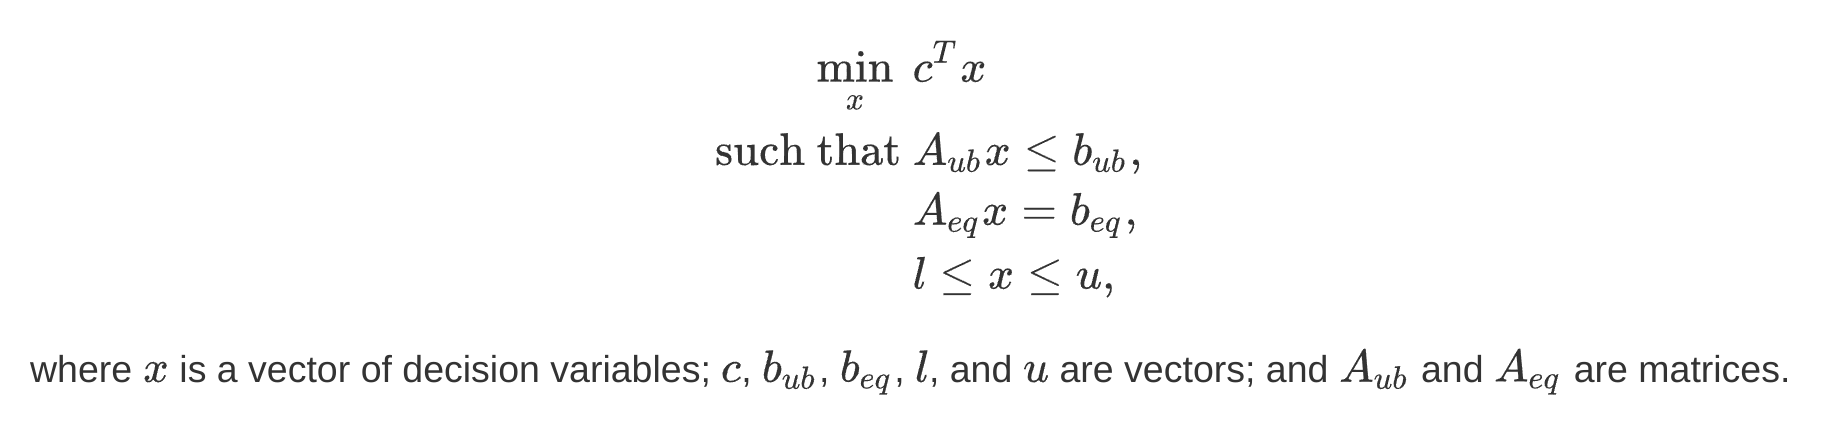


$ \text{Será utilizado o solver internos do Scipy, mais especificamente o HiGHS Simplex.}$
$ \text{O nome HiGHS vem de seus criadores H.all, I.vet G.alabova, H.uangfu e S.chork.}$


In [13]:
scipy_status = {
        0 : 'Optimization terminated successfully',
        1 : 'Iteration limit reached',
        2 : 'Problem appears to be infeasible',
        3 : 'Problem appears to be unbounded',
        4 : 'Numerical difficulties encountered',
}

In [14]:
def optimize_scipy(model_configs: dict[str, Any]):
    n_vars = model_configs.get('n_vars')
    cases = model_configs.get('cases')
    solvers = model_configs.get('solvers')
    has_options = model_configs.get('has_options')
    solver_options = model_configs.get('options')
    integrality = model_configs.get('integrality')

    for level, params in cases.items():
        critical_value = params.get('value')
        durations = params.get('durations').keys()

        for duration in durations:
            bound = params.get('durations').get(duration)

            print_model_specs(
                level, duration, critical_value, n_vars, bound, 24)

            coefs = np.array(list(map(lambda k: k * duration, Ks)))

            objective = coefs
            constraints = [-coefs]
            constr_limits = [-critical_value]

            options = {}

            if has_options:
                options = solver_options

            for method in solvers:
                start = time.time()
                res = linprog(
                    objective,
                    A_eq=constraints,
                    b_eq=constr_limits,
                    bounds=[bound,] * n_vars,
                    method=method,
                    integrality=integrality,
                    options=options
                )
                end = time.time()

                print(f'\nSOLVER {method.upper()}')
                print('=' * 20)
                print('')

                if res.status != 0:
                    print(f'Status do solver : {scipy_status.get(res.status)}')
                print(f'Tempo de execução :  {end - start:.4f} s')
                print(f'Condição de término : {res.message}')
                print('')

                if res.success:
                    print('RESULTADOS')
                    print('-'*11)

                    for n, v in enumerate(res.x):
                        if n % 2 == 0:
                            print(f'{f"i[{n+1}]:":<4} {v:>5.1f}', end='')
                        else:
                            print(f'  |  {f"i[{n+1}]:":<4} {v:>5.1f}')

                    print('\n')
                    print(f'Valor alcançado pela função objetivo: {res.fun:.8f}')

                print('')


In [15]:
# SOLVERS
# highs-ds -- HiGHS Simplex
# highs-ipm -- HiGHS interior-point
# highs -- Escolhe automaticamente simplex ou interior-point

solvers_scipy =['highs']
model_config = {
    'n_vars': len(regions),
    'cases': {
        'low': {
            'value': water_level_rates['low'],
            'durations': {
                60: (1, 21),
                120: (1, 11),
                240: (1, 7),
            # },
        },
        'medium': {
            'value': water_level_rates['medium'],
            # 'durations': {
                60: (1, 51),
                120: (1, 26),
                240: (1, 14),
            },
        },
        'high': {
            'value': water_level_rates['high'],
            'durations': {
                60: (1, 99),
                120: (1, 50),
                240: (1, 26),
            },
        },
    },
    'solvers': solvers_scipy,
    'has_options': True,
    'options': {
        'disp': False,
    },
    'integrality': [1] * len(regions),
}

optimize_scipy(model_config)

**********************************************************************
Nível de criticidade     BAIXO
Duração da chuva         60 min
Nível crítico da taxa    0.100 m/h | 10.0 cm/h
Quantidade de variáveis  09
Limite inferior          01 mm
Limite superior          21 mm
**********************************************************************

SOLVER HIGHS

Tempo de execução :  0.2382 s
Condição de término : Optimization terminated successfully. (HiGHS Status 7: Optimal)

RESULTADOS
-----------
i[1]:   8.0  |  i[2]:  21.0
i[3]:  18.0  |  i[4]:  21.0
i[5]:  21.0  |  i[6]:  17.0
i[7]:  21.0  |  i[8]:  21.0
i[9]:  21.0

Valor alcançado pela função objetivo: 0.10000052

**********************************************************************
Nível de criticidade     BAIXO
Duração da chuva         120 min
Nível crítico da taxa    0.100 m/h | 10.0 cm/h
Quantidade de variáveis  09
Limite inferior          01 mm
Limite superior          11 mm
********************************************************